# Depth-Based Performance Analysis

This notebook analyzes the performance of a hierarchical object detection model based on the depth of the ground truth classes in the hierarchy. It helps answer the question: **"Does the model perform better or worse on classes that are deeper (more specific) in the hierarchy?"**

The process is as follows:
1.  **Configuration**: Set the path to the model config and the trained model weights (`.pth` file).
2.  **Data Loading**: Load the model, dataset, and class hierarchy.
3.  **Inference & Embedding Collection**: Run inference on a subset of the dataset. A forward hook is used to capture the actual query embeddings generated by the model for each detection.
4.  **Hierarchical Matching**: Use a non-greedy matching algorithm to pair predictions with ground truth annotations.
5.  **Metric Calculation**: For each matched pair, calculate the hierarchical F1 score and record the depth of the ground truth class.
6.  **Visualization**: Plot the average hierarchical F1 score at each depth level, providing a clear view of performance across the hierarchy.

In [1]:
import sys
import os
import warnings
from typing import List, Dict, Any, Optional, Tuple, Set

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Add project root to the Python path to allow for module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Change the current working directory to the project root
os.chdir(project_root)

print(f"Project root set to: {os.getcwd()}")

Project root set to: /root/hierarchical-object-detection


In [2]:
# === Imports ===
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from mmengine import Config
from mmengine.fileio import load
from mmengine.registry import init_default_scope
from mmdet.registry import DATASETS
from mmdet.utils import update_data_root
from mmdet.apis import init_detector, inference_detector

from hod.utils.tree import HierarchyTree

# Import shared utilities from the analysis tools script
from tools.analysis_tools.detection_projection_plot import (
    EmbeddingCollector, 
    non_greedy_hierarchical_matching,
    get_target_classifier
)

In [3]:
# === Configuration ===

# --- Model and Dataset ---
# Define the model to analyze.
MODEL_CONFIG = {
    "config_path": "configs/hod/models/hierarchical_dino_func_ablation/hi_dino-r50-hfl10-ecl-sep-raw-eucl_improved_8xb2-36e_aircraft-func.py",
    "model_path": "work_dirs/hi_dino-r50-hfl3-ecl-sep-raw-eucl_improved_8xb2-36e_aircraft-func/epoch_36.pth" # <-- SET MANUALLY
}

# --- Analysis Parameters ---
# Maximum number of images to process from the dataset.
# Set to a smaller number for quick tests, or a larger number for a more robust analysis.
MAX_IMAGES_TO_PROCESS = 200

# Score threshold for filtering detections.
SCORE_THRESHOLD = 0.3

# IoU threshold for matching predictions to ground truth.
IOU_THRESHOLD = 0.5

### Core Logic: Helper Classes and Functions

This cell contains all the necessary classes and functions to perform the analysis. It includes:
-   **`EmbeddingCollector`**: A class to capture query embeddings from the model using hooks.
-   **Model Loading Utilities**: Functions to correctly identify and load the model and its prototype embeddings.
-   **Hierarchical Matching**: The `non_greedy_hierarchical_matching` algorithm to accurately pair predictions and ground truths.
-   **Analysis and Plotting**: Functions to run the inference, calculate depth-based metrics, and generate the final plot.

### Execute Analysis

The following cell runs the main analysis pipeline:
1.  Loads the configuration and dataset.
2.  Initializes the model and hierarchy tree.
3.  Runs inference on the specified number of images, collecting performance metrics at each depth level.
4.  Generates and displays the final plot.

In [15]:
# =============================================================================
# ANALYSIS FUNCTION
# =============================================================================

def run_analysis():
    """Main function to run the full analysis and return data for plotting."""
    # --- 1. Load Configuration ---
    print("Loading configuration...")
    cfg = Config.fromfile(MODEL_CONFIG['config_path'])
    update_data_root(cfg)
    init_default_scope(cfg.get('default_scope', 'mmdet'))

    # --- 2. Load Hierarchy and Labels ---
    print("Loading hierarchy and labels...")
    dataset_cfg = cfg.test_dataloader.dataset
    ann_file = dataset_cfg.get('data_root') + dataset_cfg.get('ann_file')
    if not ann_file:
        raise ValueError("Annotation file (containing taxonomy) not specified in the dataset config.")
    
    annotations = load(ann_file)
    taxonomy = annotations.get('taxonomy')
    if not taxonomy:
        raise ValueError(f"Could not find 'taxonomy' key in annotation file: {ann_file}")

    hierarchy = HierarchyTree(taxonomy)
    labels = DATASETS.build(dataset_cfg).metainfo['classes']

    # --- 3. Load Model and Prototypes ---
    print("Loading model...")
    try:
        model = init_detector(MODEL_CONFIG['config_path'], MODEL_CONFIG['model_path'], device='cuda:0')
        classifier = get_target_classifier(model)
        if not (classifier and hasattr(classifier, 'prototypes')):
            raise RuntimeError("Could not find prototypes in the target classifier.")
        prototypes = classifier.prototypes.detach().cpu().numpy()
        # Extract temperature for sigmoid conversion, default to 1.0 if not present
        temperature = getattr(classifier, 't', 1.0)
        if isinstance(temperature, torch.Tensor):
            temperature = temperature.item()
            
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

    # --- 4. Prepare Data for Plots ---
    # a) Prototype Distance to Root vs. Depth
    print("Calculating prototype distances to root...")
    
    # Find the root prototype
    root_name = hierarchy.root.name
    if root_name not in labels:
        raise ValueError(f"Root node '{root_name}' not found in the dataset's classes.")
    root_idx = labels.index(root_name)
    root_prototype = prototypes[root_idx]
    
    # Calculate distance for each prototype to the root prototype
    distances_to_root = np.linalg.norm(prototypes - root_prototype, axis=1)
    depths_from_labels = [hierarchy.class_to_node[label].get_depth() for label in labels]

    # Filter out depth 0 (the root itself) for the first plot
    plot1_depths = []
    plot1_distances = []
    for depth, dist in zip(depths_from_labels, distances_to_root):
        if depth > 0:
            plot1_depths.append(depth)
            plot1_distances.append(dist)

    # b) Margin vs. Depth Analysis
    print(f"Running inference on {MAX_IMAGES_TO_PROCESS} images for margin analysis...")
    dataset = DATASETS.build(dataset_cfg)
    depth_metrics = {}
    
    collector = EmbeddingCollector()
    if not collector.register_hooks(model):
        print("Error: Failed to register hooks for embedding collection.")
        return None, None

    try:
        for i in tqdm(range(min(MAX_IMAGES_TO_PROCESS, len(dataset))), desc="Processing images"):
            collector.clear()
            data_info = dataset.get_data_info(i)
            gt_instances = data_info.get('instances', [])
            img_path = data_info['img_path']

            if not gt_instances:
                continue

            with torch.no_grad():
                result = inference_detector(model, img_path)
            
            if hasattr(result.pred_instances, 'bbox_index'):
                query_embeddings = collector.get_embeddings_for_detections(result.pred_instances.bbox_index)
                if query_embeddings is not None:
                    result.pred_instances.query_embeddings = torch.from_numpy(query_embeddings)

            matched_pairs = non_greedy_hierarchical_matching(
                result.pred_instances, gt_instances, hierarchy, labels, SCORE_THRESHOLD, IOU_THRESHOLD
            )
            
            for pair in matched_pairs:
                query_embedding = pair.get('query_embedding')
                if query_embedding is None:
                    continue

                # Calculate distances (logits) for the single query against all prototypes
                distances = np.linalg.norm(prototypes - query_embedding, axis=1)
                
                # Convert distances to probabilities using sigmoid
                logits = -distances * temperature
                probabilities = 1 / (1 + np.exp(-logits))
                
                # Sort probabilities to find top 2
                sorted_probs = np.sort(probabilities)[::-1] # Sort descending
                
                if len(sorted_probs) >= 2:
                    margin = sorted_probs[0] - sorted_probs[1]
                    # Get top-1 predicted class index and label
                    top1_idx = np.argmax(probabilities)
                    top1_label = labels[top1_idx]
                    pred_depth = hierarchy.class_to_node[top1_label].get_depth()
                    if pred_depth not in depth_metrics:
                        depth_metrics[pred_depth] = []
                    depth_metrics[pred_depth].append(margin)

    finally:
        collector.remove_hooks()

    margin_depths = []
    margin_values = []
    for depth, margins in depth_metrics.items():
        for margin in margins:
            margin_depths.append(depth)
            margin_values.append(margin)

    # --- 5. Return Data for Plotting ---
    print("Analysis complete. Returning data for plotting.")
    plot1_data = (plot1_depths, plot1_distances)
    plot2_data = (margin_depths, margin_values)
    return plot1_data, plot2_data


# --- Execute the analysis ---
plot1_data, plot2_data = run_analysis()

Loading configuration...
Loading hierarchy and labels...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model...
Loads checkpoint by local backend from path: work_dirs/hi_dino-r50-hfl3-ecl-sep-raw-eucl_improved_8xb2-36e_aircraft-func/epoch_36.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: bbox_head.loss_embed._neg_cand_flat, bbox_head.loss_embed._neg_ptrs

Calculating prototype distances to root...
Running inference on 200 images for margin analysis...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Targeting classification branch: cls_branches.5 (branch 5 of 7 total - second-to-last)
Registering hook on: bbox_head.cls_branches.5
Successfully registered method hook on bbox_head.cls_branches.5
Successfully registered 1 hooks


Processing images: 100%|██████████| 200/200 [00:20<00:00,  9.68it/s]

Successfully restored 1 original methods
Analysis complete. Returning data for plotting.


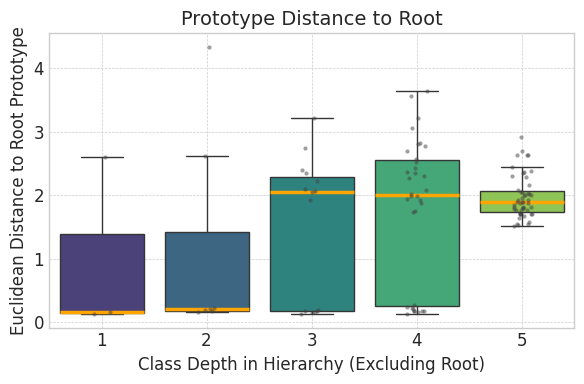

In [16]:
# =============================================================================
# PLOT 1: PROTOTYPE DISTANCE TO ROOT VS. DEPTH
# =============================================================================

# --- Unpack Data ---
plot1_depths, plot1_distances = plot1_data

# --- Generate Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 12, 'ytick.labelsize': 12
})

plt.figure(figsize=(6, 4))
ax1 = sns.boxplot(x=plot1_depths, y=plot1_distances, palette="viridis", showfliers=False, medianprops={'linewidth': 2.5, 'color': 'orange'})
sns.stripplot(x=plot1_depths, y=plot1_distances, ax=ax1, color=".25", size=3, alpha=0.5)

plt.xlabel("Class Depth in Hierarchy (Excluding Root)")
plt.ylabel("Euclidean Distance to Root Prototype")
plt.title("Prototype Distance to Root", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


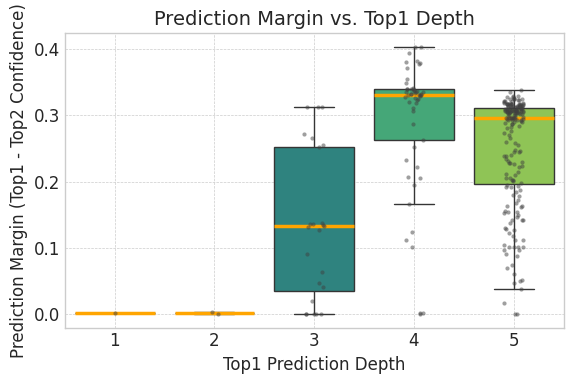

In [18]:
# =============================================================================
# PLOT 2: PREDICTION MARGIN VS. GROUND TRUTH DEPTH
# =============================================================================

# --- Unpack Data ---
margin_depths, margin_values = plot2_data

# --- Generate Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 12, 'ytick.labelsize': 12
})


plt.figure(figsize=(6, 4))
if margin_depths:
    ax2 = sns.boxplot(x=margin_depths, y=margin_values, palette="viridis", showfliers=False, medianprops={'linewidth': 2.5, 'color': 'orange'})
    sns.stripplot(x=margin_depths, y=margin_values, ax=ax2, color=".25", size=3, alpha=0.5)
    plt.xlabel("Top1 Prediction Depth")
    plt.ylabel("Prediction Margin (Top1 - Top2 Confidence)")
    plt.title("Prediction Margin vs. Top1 Depth", fontsize=14)
else:
    plt.text(0.5, 0.5, 'No margin data to display.', ha='center', va='center')
    plt.title("Prediction Margin vs. Top1 Depth", fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()